 ---

# Исследование оттока клиентов банка

---

<u>**Цель проекта**</u>: Построение модели для прогноза оттока клиентов банка на основании исторических данных;

<u>**Сферы деятельности компаний**</u>: Банковская сфера;

<u>**Навыки и инструменты**</u>: Порядковое кодирование категориальных признаков, масштабирование численных признаков, изменение баланса классов (Upsampling, Downsampling)

### Описание данных

**Признаки**:

- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

**Целевой признак**:
- *Exited* — факт ухода клиента


## 1. Загрузка, изучение и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math as m
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 10 #закомментировать в случае возникновения проблем :)
sns.set(rc={'figure.figsize':(14,10)})

In [3]:
import warnings
warnings.simplefilter('ignore')

from tqdm.notebook import tqdm

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  PassiveAggressiveClassifier, Perceptron)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import (accuracy_score, r2_score, f1_score, mean_squared_error,
                             mean_absolute_error, precision_score, recall_score,
                             precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score)

import joblib

In [5]:
data = pd.read_csv(...)
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


После изучения данных видно, что:

- Имеются пропуски в *'Tenure'*;
- В столбце *'Tenure'* содержатся данные типа float64, а не int64;
- Неинформативный столбец *'RowNumber'*;
- Столбец *'Balance'* для удобства желательно привести к типу int64.

In [7]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Пропуски в столбце *'Tenure'* можно заменить нулями и привести данные к типу *'int64'*:


In [8]:
data['Tenure'] = data['Tenure'].fillna(0).astype(np.int64)

In [9]:
data['Balance'] = data['Balance'].astype(np.int64)

In [10]:
data.columns.tolist()

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

Фамилии клиентов нам не нужны — они никак не связаны с самим явлением оттока клиентов из банка. То же касается и столбца *'CustomerId'*.

In [11]:
data = data[['CreditScore',
             'Geography',
             'Gender',
             'Age',
             'Tenure',
             'Balance',
             'NumOfProducts',
             'HasCrCard',
             'IsActiveMember',
             'EstimatedSalary',
             'Exited']]

Зададим столбцами более удобные имена:

In [12]:
new_columns = ['credit_score',
               'geography',
               'gender',
               'age',
               'tenure',
               'balance',
               'number_of_products',
               'has_credit_card',
               'is_active_member',
               'estimated_salary',
               'exited']
data.columns = new_columns

Взглянем на типы данных:

In [13]:
data.dtypes

credit_score            int64
geography              object
gender                 object
age                     int64
tenure                  int64
balance                 int64
number_of_products      int64
has_credit_card         int64
is_active_member        int64
estimated_salary      float64
exited                  int64
dtype: object

С типами данных всё в порядке.

<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Выводы: </h3>
    <ul>
        <li><b>Загружен датасет, получена общая информация</b>;</li>
        <li><b>Заполнены пропуски в столбце 'Tenure'</b>;</li>
        <li><b>Исключены фамилии клиентов — они никак не коррелируют с целевым признаком</b>;</li>
        <li><b>Переименованы столбцы</b>.</li>
    </ul>
</div>

## 2. Кодирование признаков, деление выборки, масштабирование и изучение баланса классов

Воспользуемся **порядковым кодированием**, чтобы из категориальных признаков получить численные:

In [14]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [15]:
target = data_ohe['exited']
features = data_ohe.drop(['exited'], axis=1)

In [16]:
df_features, features_valid, df_target, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.2,
                                                                              random_state=12345
)

features_train, features_test, target_train, target_test = train_test_split(df_features,
                                                                              df_target,
                                                                              test_size=0.25,
                                                                              random_state=12345
)



In [17]:
print('Доля обучающей выборки: {:.0%}'.format(len(features_train)/len(data_ohe)))
print('Доля валидационной выборки: {:.0%}'.format(len(features_valid)/len(data_ohe)))
print('Доля тестовой выборки: {:.0%}'.format(len(features_test)/len(data_ohe)))

Доля обучающей выборки: 60%
Доля валидационной выборки: 20%
Доля тестовой выборки: 20%


In [18]:
data_ohe.columns.tolist()

['credit_score',
 'age',
 'tenure',
 'balance',
 'number_of_products',
 'has_credit_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'geography_Germany',
 'geography_Spain',
 'gender_Male']

**Масштабируем численные признаки**, прибегнув к **стандартизации**:

In [19]:
numeric = ['credit_score',
           'age',
           'tenure',
           'balance',
           'number_of_products',
           'estimated_salary']

scaler = StandardScaler().fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Посмотрим, насколько сбалансированы классы:

In [20]:
data_ohe['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

**Положительный класс встречается почти в четыре раза реже, чем отрицательный**.

<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Выводы: </h3>
    <ul>
        <li><b>Порядковым кодированием из категориальных признаков получены численные</b>;</li>
        <li><b>Произведено разбиение на обучающую, валидационную и тестовую выборки, выделен целевой признак</b>;</li>
        <li><b>Численные признаки масштабированы  методом стандартизации</b>;</li>
        <li><b>Изучен баланс классов: положительный класс встречается реже отрицательного</b>.</li>
    </ul>
</div>

## 3. Поиск подходящей модели и оптимальных гиперпараметров, оценка эффективности

Для решения задачи бинарной классификации будем **обучать различные модели**, **подбирать оптимальные гиперпараметры**, а затем **оценивать полученные результаты**. Для каждой модели рассмотрим 

В качестве критерия выберем **F1-меру** и будем добиваться её значений в пределах от 0,59 до 1.

Параллельно будем также наблюдать за **моделями, обученными без учёта дисбаланса классов**.

**1. Логистическая регрессия**

1.1. Обучим **логистическую регрессию без учёта дисбаланса классов**:

In [21]:
logistic_regression_unbalanced = (LogisticRegression(random_state=12345,
                                                     class_weight=None,
                                                     n_jobs=-1,
                                                     solver='newton-cg')
                                  .fit(features_train, target_train))

logistic_regression_unbalanced_predicted_valid = logistic_regression_unbalanced.predict(features_valid)

print('Точность: {:.4f}'.format(precision_score(target_valid,
                                                logistic_regression_unbalanced_predicted_valid)))
print('Полнота: {:.4f}'.format(recall_score(target_valid,
                                            logistic_regression_unbalanced_predicted_valid)))
print('F1-мера: {:.4f}'.format(f1_score(target_valid,
                                        logistic_regression_unbalanced_predicted_valid)))

Точность: 0.5915
Полнота: 0.1967
F1-мера: 0.2953


Точность нельзя назвать слишком плохой, а вот с полнотой наблюдаются серьёзные проблемы, и низкое значение F1-меры это подтверждает.

1.2. **Сбалансируем классы взвешиванием** и посмотрим, как изменились точность и полнота:

In [22]:
logistic_regression_weighted = (LogisticRegression(random_state=12345,
                                                      class_weight='balanced',
                                                      n_jobs=-1,
                                                      solver='liblinear')
                                   .fit(features_train, target_train))

logistic_regression_weighted_predicted_valid = logistic_regression_weighted.predict(features_valid)

print('Точность: {:.4f}'.format(precision_score(target_valid,
                                                logistic_regression_weighted_predicted_valid)))
print('Полнота: {:.4f}'.format(recall_score(target_valid,
                                            logistic_regression_weighted_predicted_valid)))
print('F1-мера: {:.4f}'.format(f1_score(target_valid,
                                        logistic_regression_weighted_predicted_valid)))

Точность: 0.3926
Полнота: 0.6979
F1-мера: 0.5025


Видно, что в сбалансированной по классам выборке точность упала, однако полнота возросла существенно, и F1-мера превысила значение 0,5.

Посмотрим, как изменится F1-мера, если сбалансировать классы, применяя **upsampling** и **downsampling**:

In [23]:
def upsample_class_1(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

def downsample_class_0(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled



features_train_upsampled, target_train_upsampled = upsample_class_1(features_train,
                                                                    target_train,
                                                                    4)

features_train_downsampled, target_train_downsampled = downsample_class_0(features_train,
                                                                          target_train,
                                                                          0.1)


1.3. **Upsampling**:

In [24]:
logistic_regression_upsampled = (LogisticRegression(random_state=12345,
                                                      class_weight=None,
                                                      n_jobs=-1,
                                                      solver='liblinear')
                                   .fit(features_train_upsampled, target_train_upsampled))

logistic_regression_upsampled_predicted_valid = logistic_regression_upsampled.predict(features_valid)

print('Точность: {:.4f}'
      .format(precision_score(target_valid, logistic_regression_upsampled_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid, logistic_regression_upsampled_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid, logistic_regression_upsampled_predicted_valid)))

Точность: 0.3907
Полнота: 0.7073
F1-мера: 0.5033


1.4. **Downsampling**:

In [25]:
logistic_regression_downsampled = (LogisticRegression(random_state=12345,
                                                      class_weight=None,
                                                      n_jobs=-1,
                                                      solver='liblinear')
                                   .fit(features_train_downsampled, target_train_downsampled))

logistic_regression_downsampled_predicted_valid = logistic_regression_downsampled.predict(features_valid)

print('Точность: {:.4f}'
      .format(precision_score(target_valid, logistic_regression_downsampled_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid, logistic_regression_downsampled_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid, logistic_regression_downsampled_predicted_valid)))

Точность: 0.2743
Полнота: 0.9251
F1-мера: 0.4231


Очевидно, что **взвешивание классов гораздо эффективнее копирования части объектов редкого класса или удаления части объектов распространённого**.

До порогового значения 0,59 ещё далеко. Для того, чтобы достичь искомого значения F1-меры, обучим ещё 2 модели, посмотрим на их применимость и выберем наиболее эффективную:

**2. Случайный лес:**

С помощью **RandomizedSearchCV** будем находить значения, приближённые к оптимальным.

Ограничим число активных потоков до 4, чтобы соблюсти баланс между используемой вычислительной мощностью и остаточной мультизадачностью:

2.1. **Обучение без учёта дисбаланса классов**:

In [26]:
%%time

parameters = {'n_estimators': range(1, 300),
              'max_depth': range (1, 30)}

random_forest_classifier_unbalanced_parameters = (
    RandomizedSearchCV(RandomForestClassifier(
    criterion='entropy',
    random_state=12345,
    class_weight=None,
    n_jobs=-1),
                       parameters,
                       n_iter=1000,
                       scoring='f1',
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train, target_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 11.5min finished


Wall time: 11min 30s


In [27]:
random_forest_classifier_unbalanced_parameters.best_params_

{'n_estimators': 193, 'max_depth': 20}

In [28]:
random_forest_classifier_unbalanced = (
    RandomForestClassifier
    .set_params(RandomForestClassifier(random_state=12345,
                                       class_weight=None,
                                       n_jobs=-1),
                **random_forest_classifier_unbalanced_parameters
                .best_params_)
    .fit(features_train, target_train))

random_forest_classifier_unbalanced_predicted_valid = (random_forest_classifier_unbalanced
                                                       .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid, random_forest_classifier_unbalanced_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid, random_forest_classifier_unbalanced_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid, random_forest_classifier_unbalanced_predicted_valid)))

Точность: 0.7661
Полнота: 0.4450
F1-мера: 0.5630


2.2. Сбалансируем классы **взвешиванием**:

In [29]:
%%time

parameters = {'n_estimators': range(1, 300),
              'max_depth': range (1, 30)}

random_forest_classifier_weighted_parameters = (
    RandomizedSearchCV(RandomForestClassifier(criterion='entropy',
                                              random_state=12345,
                                              class_weight='balanced',
                                              n_jobs=-1),
                       parameters,
                       scoring='f1',
                       n_iter=1000,
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train, target_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed: 10.3min


Wall time: 11min 15s


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 11.2min finished


In [30]:
random_forest_classifier_weighted_parameters.best_params_

{'n_estimators': 56, 'max_depth': 9}

In [31]:
random_forest_classifier_weighted = (
    RandomForestClassifier
    .set_params(RandomForestClassifier(random_state=12345,
                                       class_weight='balanced',
                                       n_jobs=-1),
                **random_forest_classifier_weighted_parameters
                .best_params_)
    .fit(features_train, target_train))

random_forest_classifier_weighted_predicted_valid = (random_forest_classifier_weighted
                                                    .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              random_forest_classifier_weighted_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           random_forest_classifier_weighted_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       random_forest_classifier_weighted_predicted_valid)))

Точность: 0.6234
Полнота: 0.6745
F1-мера: 0.6479


2.3. Сбалансируем классы методом **upsampling**:

In [32]:
%%time

parameters = {'n_estimators': range(1, 300),
              'max_depth': range (1, 30)}

random_forest_classifier_upsampled_parameters = (
    RandomizedSearchCV(RandomForestClassifier(criterion='entropy',
                                              random_state=12345,
                                              class_weight=None,
                                              n_jobs=-1),
                       parameters,
                       scoring='f1',
                       n_iter=1000,
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train_upsampled, target_train_upsampled))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 14.9min finished


Wall time: 14min 56s


In [33]:
random_forest_classifier_upsampled_parameters.best_params_

{'n_estimators': 206, 'max_depth': 27}

In [34]:
random_forest_classifier_upsampled = (RandomForestClassifier
                            .set_params(RandomForestClassifier(random_state=12345,
                                                               class_weight=None,
                                                               n_jobs=-1),
                                        **random_forest_classifier_upsampled_parameters
                                        .best_params_)
                            .fit(features_train_upsampled, target_train_upsampled))

random_forest_classifier_upsampled_predicted_valid = (random_forest_classifier_upsampled
                                                                .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              random_forest_classifier_upsampled_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           random_forest_classifier_upsampled_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       random_forest_classifier_upsampled_predicted_valid)))

Точность: 0.6805
Полнота: 0.5386
F1-мера: 0.6013


2.4. Взвесим классы методом **downsampling**:

In [35]:
%%time

parameters = {'n_estimators': range(1, 300),
              'max_depth': range (1, 30)}

random_forest_classifier_downsampled_parameters = (
    RandomizedSearchCV(RandomForestClassifier(criterion='entropy',
                                              random_state=12345,
                                              class_weight=None,
                                              n_jobs=-1),
                       parameters,
                       scoring='f1',
                       n_iter=1000,
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train_downsampled, target_train_downsampled))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  6.4min finished


Wall time: 6min 26s


In [36]:
random_forest_classifier_downsampled_parameters.best_params_

{'n_estimators': 272, 'max_depth': 8}

In [37]:
random_forest_classifier_downsampled = (RandomForestClassifier
                            .set_params(RandomForestClassifier(random_state=12345,
                                                               class_weight=None,
                                                               n_jobs=-1),
                                        **random_forest_classifier_downsampled_parameters
                                        .best_params_)
                            .fit(features_train_downsampled, target_train_downsampled))

random_forest_classifier_downsampled_predicted_valid = (random_forest_classifier_downsampled
                                                        .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              random_forest_classifier_downsampled_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           random_forest_classifier_downsampled_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       random_forest_classifier_downsampled_predicted_valid)))

Точность: 0.3273
Полнота: 0.9321
F1-мера: 0.4845


**3. Классификатор экстремально рандомизированных деревьев:**

3.1. Обучим модель **без учёта дисбаланса классов**:

In [38]:
%%time

parameters = {'n_estimators': range(0, 300),
             'max_depth': range (0, 30)}

extra_trees_classifier_unbalanced_parameters = (RandomizedSearchCV(ExtraTreesClassifier(criterion='entropy',
                                                                             random_state=12345,
                                                                             class_weight=None,
                                                                             n_jobs=-1),
                                                        parameters,
                                                        n_iter=1000,
                                                        scoring='f1',
                                                        n_jobs=-1,
                                                        refit=True,
                                                        verbose=3)
                                     .fit(features_train, target_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed:  7.0min


Wall time: 7min 35s


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  7.6min finished


In [39]:
extra_trees_classifier_unbalanced_parameters.best_params_

{'n_estimators': 43, 'max_depth': 29}

In [40]:
extra_trees_classifier_unbalanced = (ExtraTreesClassifier
                            .set_params(ExtraTreesClassifier(random_state=12345,
                                                             class_weight=None,
                                                             n_jobs=-1),
                                        **extra_trees_classifier_unbalanced_parameters
                                        .best_params_)
                            .fit(features_train, target_train))

extra_trees_classifier_unbalanced_predicted_valid = (extra_trees_classifier_unbalanced
                                                     .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              extra_trees_classifier_unbalanced_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           extra_trees_classifier_unbalanced_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       extra_trees_classifier_unbalanced_predicted_valid)))

Точность: 0.7265
Полнота: 0.4169
F1-мера: 0.5298


3.2. Сбалансируем классы **взвешиванием**:

In [41]:
%%time

parameters = {'n_estimators': range(0, 300),
             'max_depth': range (0, 30)}

extra_trees_classifier_weighted_parameters = (
    RandomizedSearchCV(ExtraTreesClassifier(criterion='entropy',
                                            random_state=12345,
                                            class_weight='balanced',
                                            n_jobs=-1),
                       parameters,
                       n_iter=1000,
                       scoring='f1',
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train, target_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  7.7min finished


Wall time: 7min 42s


In [42]:
extra_trees_classifier_weighted_parameters.best_params_

{'n_estimators': 287, 'max_depth': 12}

In [43]:
extra_trees_classifier_weighted = (ExtraTreesClassifier
                            .set_params(ExtraTreesClassifier(random_state=12345,
                                                             class_weight=None,
                                                             n_jobs=-1),
                                        **extra_trees_classifier_weighted_parameters
                                        .best_params_)
                            .fit(features_train, target_train))

extra_trees_classifier_weighted_predicted_valid = (extra_trees_classifier_weighted
                                                   .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              extra_trees_classifier_weighted_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           extra_trees_classifier_weighted_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       extra_trees_classifier_weighted_predicted_valid)))

Точность: 0.8111
Полнота: 0.3419
F1-мера: 0.4811


3.3. Сбалансируем классы методом **upsampling**:

In [44]:
%%time

parameters = {'n_estimators': range(0, 200),
             'max_depth': range (0, 30)}

extra_trees_classifier_upsampled_parameters = (
    RandomizedSearchCV(ExtraTreesClassifier(criterion='entropy',
                                            random_state=12345,
                                            class_weight=None,
                                            n_jobs=-1),
                       parameters,
                       n_iter=1000,
                       scoring='f1',
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train_upsampled, target_train_upsampled))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed:  6.0min


Wall time: 6min 29s


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  6.5min finished


In [45]:
extra_trees_classifier_upsampled_parameters.best_params_

{'n_estimators': 44, 'max_depth': 26}

In [46]:
extra_trees_classifier_upsampled = (ExtraTreesClassifier
                            .set_params(ExtraTreesClassifier(random_state=12345,
                                                             class_weight=None,
                                                             n_jobs=-1),
                                        **extra_trees_classifier_upsampled_parameters
                                        .best_params_)
                            .fit(features_train_upsampled, target_train_upsampled))

extra_trees_classifier_upsampled_predicted_valid = (extra_trees_classifier_upsampled
                                                              .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              extra_trees_classifier_upsampled_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           extra_trees_classifier_upsampled_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       extra_trees_classifier_upsampled_predicted_valid)))

Точность: 0.6898
Полнота: 0.3958
F1-мера: 0.5030


3.4. Сбалансируем классы методом **downsampling**:

In [47]:
%%time

parameters = {'n_estimators': range(0, 200),
             'max_depth': range (0, 30)}

extra_trees_classifier_downsampled_parameters = (
    RandomizedSearchCV(ExtraTreesClassifier(criterion='entropy',
                                            random_state=12345,
                                            class_weight=None,
                                            n_jobs=-1),
                       parameters,
                       n_iter=1000,
                       scoring='f1',
                       n_jobs=-1,
                       refit=True,
                       verbose=3)
    .fit(features_train_downsampled, target_train_downsampled))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3860 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4596 tasks      | elapsed:  3.5min


Wall time: 3min 51s


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.9min finished


In [48]:
extra_trees_classifier_downsampled_parameters.best_params_

{'n_estimators': 120, 'max_depth': 8}

In [49]:
extra_trees_classifier_downsampled = (ExtraTreesClassifier
                            .set_params(ExtraTreesClassifier(random_state=12345,
                                                             class_weight=None,
                                                             n_jobs=-1),
                                        **extra_trees_classifier_downsampled_parameters
                                        .best_params_)
                            .fit(features_train_downsampled, target_train_downsampled))

extra_trees_classifier_downsampled_predicted_valid = (extra_trees_classifier_downsampled
                                                                .predict(features_valid))

print('Точность: {:.4f}'
      .format(precision_score(target_valid,
                              extra_trees_classifier_downsampled_predicted_valid)))
print('Полнота: {:.4f}'
      .format(recall_score(target_valid,
                           extra_trees_classifier_downsampled_predicted_valid)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_valid,
                       extra_trees_classifier_downsampled_predicted_valid)))

Точность: 0.2897
Полнота: 0.9532
F1-мера: 0.4443


In [50]:
data_f1 = [
    ['Логистическая регрессия',
     f1_score(target_valid, logistic_regression_unbalanced_predicted_valid),
     f1_score(target_valid, logistic_regression_weighted_predicted_valid),
     f1_score(target_valid, logistic_regression_upsampled_predicted_valid),
     f1_score(target_valid, logistic_regression_downsampled_predicted_valid)],
           
    ['Случайный лес',
     f1_score(target_valid, random_forest_classifier_unbalanced_predicted_valid),
     f1_score(target_valid, random_forest_classifier_weighted_predicted_valid),
     f1_score(target_valid, random_forest_classifier_upsampled_predicted_valid),
     f1_score(target_valid, random_forest_classifier_downsampled_predicted_valid)],
    
    ['Экстремально рандомизированные деревья',
     f1_score(target_valid, extra_trees_classifier_unbalanced_predicted_valid),
     f1_score(target_valid, extra_trees_classifier_weighted_predicted_valid),
     f1_score(target_valid, extra_trees_classifier_upsampled_predicted_valid),
     f1_score(target_valid, extra_trees_classifier_downsampled_predicted_valid)]]

columns_f1 = ['Модель',
              'Без учёта дисбаланса классов',
              'Взвешивание',
              'Upsampling',
              'Downsampling']


data_models_f1 = pd.DataFrame(data=data_f1, columns=columns_f1)

**Подведём итоги**:

In [51]:
data_models_f1

,Модель,Без учёта дисбаланса классов,Взвешивание,Upsampling,Downsampling
0,Логистическая регрессия,0.295255,0.502530,0.503333,0.423139
1,Случайный лес,0.562963,0.647919,0.601307,0.484480
2,Экстремально рандомизированные деревья,0.529762,0.481054,0.502976,0.444323


Лидер — **случайный лес, обученный на взвешенной выборке**.

<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Выводы: </h3>
    <ul>
        <li><b>Обучены 3 различные модели</b>:</li>
        <ol>
            <li><b>Логистическая регрессия</b>;</li>
            <li><b>Случайный лес</b>;</li>
            <li><b>Экстремально рандомизированные деревья</b>;</li>
        </ol>
        <li><b>Каждая модель обучена на четырёх выборках — в первой не учтён дисбаланс классов, во второй классы сбалансированы взвешиванием, в третьей применён upsampling, а в четвёртой — downsampling</b>;</li>
        <li><b>Как и ожидалось, обучение модели на выборке, сбалансированной с помощью downsampling, даёт результаты хуже, чем при использовании upsampling, так как теряется часть объектов</b>;</li>
        <li><b>Чаще всего взвешивание даёт большую эффективность, чем upsampling или downsampling</b>;</li>
        <li><b>В качестве финальной модели выбран случайный лес, обученный на взвешенной выборке</b>.</li>
    </ul>
</div>

## 4. Обучение и проверка финальной модели

Настало время поручить перебор гиперпараметров GridSearchCV:

In [52]:
%%time

features_train_final = pd.concat([features_train] + [features_valid])
target_train_final = pd.concat([target_train] + [target_valid])

features_train_final, target_train_final = shuffle(
    features_train_final, target_train_final, random_state=12345)

parameters = {'n_estimators': range(1, 300),
              'max_depth': range (1, 30)}

#parameters = {'n_estimators': range(190, 191),
#              'max_depth': range(10, 11)}

model_final_parameters = (
    GridSearchCV(RandomForestClassifier(criterion='entropy',
                                        random_state=12345,
                                        class_weight='balanced',
                                        n_jobs=-1),
                 parameters,
                 scoring='f1',
                 n_jobs=-1,
                 refit=True,
                 verbose=3)
    .fit(features_train_final, target_train_final))

Fitting 5 folds for each of 8671 candidates, totalling 43355 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1644 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2060 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2540 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3084 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4364 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 5100 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 5900 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 6764 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 7692 tasks      | 

Wall time: 1h 59min 12s


In [53]:
model_final_parameters.best_params_

{'max_depth': 9, 'n_estimators': 147}

In [54]:
scaler = StandardScaler()
scaler.fit(features_test[numeric])

features_test_scaled = features_test
features_test_scaled[numeric] = scaler.transform(features_test[numeric])



model_final = (RandomForestClassifier(random_state=12345,
                                      n_estimators=190,
                                      max_depth=10,
                                      class_weight='balanced',
                                      n_jobs=-1)
               .fit(features_train_final, target_train_final))

model_final_predicted_test = model_final.predict(features_test_scaled)

print('Точность: {:.4f}'
      .format(precision_score(target_test, model_final_predicted_test)))
print('Полнота: {:.4f}'
      .format(recall_score(target_test, model_final_predicted_test)))
print('F1-мера: {:.4f}'
      .format(f1_score(target_test, model_final_predicted_test)))

Точность: 0.5479
Полнота: 0.6292
F1-мера: 0.5857


**Условие выполняется на тестовой выборке**, это успех.

Построим **кривую ошибок**, сравним нашу модель со случайной и оценим **площадь под кривой**:

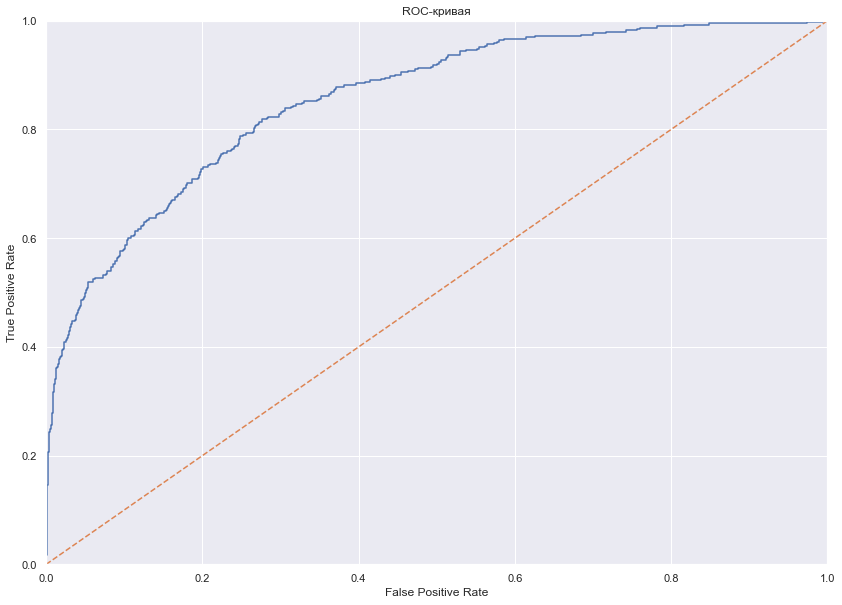

AUC-ROC:  0.8549447719747776


In [55]:
probabilities_test = model_final.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('AUC-ROC: ', auc_roc)

In [56]:
#joblib.dump(model_final, 'model_final.joblib')

<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Общие выводы: </h3>
    <ul>
        <li><b>Загружен датасет, получена общая информация</b>;</li>
        <li><b>Заполнены пропуски в данных, исключены признаки, не коррелирующие с целевым</b>;</li>
        <li><b>Порядковым кодированием из категориальных признаков получены численные</b>;</li>
        <li><b>Произведено разбиение на обучающую, валидационную и тестовую выборки, выделен целевой признак</b>;</li>
        <li><b>Обучены и оценены модели:
            <ol>
                <li><b>Логистическая регрессия</b>;</li>
                <li><b>Случайный лес</b>;</li>
                <li><b>Экстремально рандомизированные деревья</b>;</li>
            </ol>
        <li><b>Каждая модель обучена на четырёх выборках — в первой не учтён дисбаланс классов, во второй классы сбалансированы взвешиванием, в третьей применён upsampling, а в четвёртой — downsampling</b>;</li>
        <li><b>В большинстве случаев эффективность обученной модели возрастает в ряду "downsampling —> upsampling —> взвешивание классов"</b>;</li>
        <li><b>В качестве финальной модели выбран случайный лес, обученный на взвешенной выборке</b>;</li>
            <li><b>Найдены оптимальные значения гиперпараметров, достигнуто высокое значение F1-меры</b>;</li>
        <li><b>Проведено финальное тестирование</b>.</li>
    </ul>
</div>